In [ ]:
# Coins reduced to 220(277)
# Multiple PD found in given minute
# Solved : For some coins OHLCV is not avaiable
# Count PD month not matching
# solved : amrketCap is missing
# Solved : Low has negative value
# Solved : Fix drawdown

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Set up the plotly offline mode
pio.renderers.default = 'colab'

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Post_DC/df.csv")
df.drop(columns=['Unnamed: 0','Adj Close'],inplace=True, axis=1)
df['coin']=df['coin'].str[:-4]
print(df.shape)
df.head()

(182855, 29)


,Date,Open,High,Low,Close,Volume,coin,Market_Cap,Pct_Change,Month_Year,...,Open_1m_std,Open_3m_std,Open_6m_std,Open_12m_std,Open_24m_std,Open_1m_volatility,Open_3m_volatility,Open_6m_volatility,Open_12m_volatility,Open_24m_volatility
0,2019-01-01,0.002876,0.002930,0.002784,0.002913,331289.0,AAC,965.044878,0.000000,2019-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,0.002928,0.002953,0.002757,0.002872,305086.0,AAC,876.206987,-1.407486,2019-01-02,...,0.000037,0.000037,0.000037,0.000037,0.000037,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,0.002869,0.003170,0.002736,0.002900,317624.0,AAC,921.109588,0.974930,2019-01-03,...,0.000032,0.000032,0.000032,0.000032,0.000032,0.027033,0.027033,0.027033,0.027033,0.027033
3,2019-01-04,0.002898,0.002986,0.002797,0.002901,435891.0,AAC,1264.519778,0.034483,2019-01-04,...,0.000027,0.000027,0.000027,0.000027,0.000027,0.020169,0.020169,0.020169,0.020169,0.020169
4,2019-01-05,0.002898,0.003046,0.002845,0.002907,518812.0,AAC,1508.186493,0.206827,2019-01-05,...,0.000023,0.000023,0.000023,0.000023,0.000023,0.016522,0.016522,0.016522,0.016522,0.016522


# 1. Coins with highest PD

In [ ]:
pd_counts = df.groupby(['coin', 'PD']).size().unstack(fill_value=0)
pd_counts.columns = ['Non-PD', 'PD']
pd_counts['Total_Count'] = pd_counts['Non-PD'] + pd_counts['PD']

pd_counts['Non-PD(%)'] = round((pd_counts['Non-PD'] / pd_counts['Total_Count']) * 100,2)
pd_counts['PD(%)'] = round((pd_counts['PD'] / pd_counts['Total_Count']) * 100,2)

pd_counts = pd_counts.reset_index()

pd_counts=pd_counts[['coin', 'Non-PD', 'PD', 'Non-PD(%)', 'PD(%)']]
pd_counts = pd_counts.sort_values(by='PD(%)', ascending=False)
pd_counts['total']=pd_counts['Non-PD']+pd_counts['PD']
pd_counts.head()

,coin,Non-PD,PD,Non-PD(%),PD(%),total
26,BRD,1097,18,98.39,1.61,1115
155,PPT,1098,17,98.48,1.52,1115
133,NEBL,1099,16,98.57,1.43,1115
23,BNT,1099,16,98.57,1.43,1115
22,BLZ,1100,15,98.65,1.35,1115


In [ ]:
# df[(df['coin']=='ESC-USD')]

In [ ]:
data=pd_counts.head(5)

fig = go.Figure()

fig.add_trace(go.Bar(x=data["coin"],y=data["total"],name="Total",marker_color="lightskyblue"))
fig.add_trace(go.Scatter(x=data["coin"],y=data["PD(%)"],name="PD (%)",mode="lines+markers",line=dict(color="firebrick", width=2),marker=dict(size=8),yaxis="y2"  ))
fig.update_layout(title="Total Counts and PD (%) for Each Coin Pair",xaxis_title="Coin",yaxis=dict(title="Total Count",),yaxis2=dict(title="PD (%)",overlaying="y",  side="right",  range=[0, max(data["PD(%)"]) + 1]  ),
    legend=dict(x=0.85, y=1.15),template="plotly_white",width=1200,height=600)
fig.show()

# 2. Open Value and PD Events

In [ ]:
most_pd=pd_counts.sort_values(by='PD', ascending=False).head(4)
most_pd

,coin,Non-PD,PD,Non-PD(%),PD(%),total
26,BRD,1097,18,98.39,1.61,1115
155,PPT,1098,17,98.48,1.52,1115
133,NEBL,1099,16,98.57,1.43,1115
23,BNT,1099,16,98.57,1.43,1115


In [ ]:
most_pd['coin'].unique()

array(['BRD', 'PPT', 'NEBL', 'BNT'], dtype=object)

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=most_pd['coin'].unique()[:4], vertical_spacing=0.1, column_widths=[0.5, 0.5], row_heights=[0.5, 0.5])
colors = ['blue', 'green', 'orange', 'purple']

def add_trace_to_subplot(data, row, col, name, color, is_pd_event=False):
    data['Date'] = pd.to_datetime(data['Month_Year'])
    fig.add_trace(go.Scatter(x=data['Date'],y=data['Open'], mode='lines+markers',name=f'{name}',line=dict(color=color, width=1), marker=dict(size=4)), row=row, col=col)
    pd_ones = data[data['PD'] == 1]
    fig.add_trace(go.Scatter(x=pd_ones['Date'],y=pd_ones['Open'],mode='markers',name=f'PD Event',marker=dict(color='red', size=10, symbol='star'), showlegend=True if not is_pd_event else False,), row=row, col=col)

pd_event_added = False
for idx, coin in enumerate(most_pd['coin'].unique()[:4]):
    data = df[df['coin'] == coin]
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_trace_to_subplot(data, row, col, coin, colors[idx], is_pd_event=pd_event_added)
    if not pd_event_added:
        pd_event_added = True

fig.update_layout(title='Open Value and PD Events',title_x=0.5,height=600,width=1700,showlegend=True,template="plotly_white",)

for i in range(1, 5):
    fig.update_xaxes(tickmode='array',tickvals=pd.to_datetime(df['Month_Year']).dt.year.unique(),ticktext=pd.to_datetime(df['Month_Year']).dt.year.unique(),tickangle=-45,row=(i-1)//2 + 1,col=(i-1)%2 + 1)
fig.show()

# 3. Volume

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=most_pd['coin'].unique()[:4], vertical_spacing=0.1, column_widths=[0.5, 0.5], row_heights=[0.5, 0.5])
colors = ['blue', 'green', 'orange', 'purple']

def add_trace_to_subplot(data, row, col, name, color, is_pd_event=False):
    data['Date'] = pd.to_datetime(data['Month_Year'])
    fig.add_trace(go.Scatter(x=data['Date'],y=data['Volume'], mode='lines+markers',name=f'{name}',line=dict(color=color, width=1), marker=dict(size=4)), row=row, col=col)
    pd_ones = data[data['PD'] == 1]
    fig.add_trace(go.Scatter(x=pd_ones['Date'],y=pd_ones['Volume'],mode='markers',name=f'PD Event',marker=dict(color='red', size=10, symbol='star'), showlegend=True if not is_pd_event else False,), row=row, col=col)

pd_event_added = False
for idx, coin in enumerate(most_pd['coin'].unique()[:4]):
    data = df[df['coin'] == coin]
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_trace_to_subplot(data, row, col, coin, colors[idx], is_pd_event=pd_event_added)
    if not pd_event_added:
        pd_event_added = True

fig.update_layout(title='Volume and PD Events',title_x=0.5,height=600,width=1700,showlegend=True,template="plotly_white",)

for i in range(1, 5):
    fig.update_xaxes(tickmode='array',tickvals=pd.to_datetime(df['Month_Year']).dt.year.unique(),ticktext=pd.to_datetime(df['Month_Year']).dt.year.unique(),tickangle=-45,row=(i-1)//2 + 1,col=(i-1)%2 + 1)
fig.show()

# 4. Market Cap

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=most_pd['coin'].unique()[:4], vertical_spacing=0.1, column_widths=[0.5, 0.5], row_heights=[0.5, 0.5])
colors = ['blue', 'green', 'orange', 'purple']

def add_trace_to_subplot(data, row, col, name, color, is_pd_event=False):
    data['Date'] = pd.to_datetime(data['Month_Year'])
    fig.add_trace(go.Scatter(x=data['Date'],y=data['Market_Cap'], mode='lines+markers',name=f'{name}',line=dict(color=color, width=1), marker=dict(size=4)), row=row, col=col)
    pd_ones = data[data['PD'] == 1]
    fig.add_trace(go.Scatter(x=pd_ones['Date'],y=pd_ones['Market_Cap'],mode='markers',name=f'PD Event',marker=dict(color='red', size=10, symbol='star'), showlegend=True if not is_pd_event else False,), row=row, col=col)

pd_event_added = False
for idx, coin in enumerate(most_pd['coin'].unique()[:4]):
    data = df[df['coin'] == coin]
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_trace_to_subplot(data, row, col, coin, colors[idx], is_pd_event=pd_event_added)
    if not pd_event_added:
        pd_event_added = True

fig.update_layout(title='Market Cap and PD Events',title_x=0.5,height=600,width=1700,showlegend=True,template="plotly_white",)

for i in range(1, 5):
    fig.update_xaxes(tickmode='array',tickvals=pd.to_datetime(df['Month_Year']).dt.year.unique(),ticktext=pd.to_datetime(df['Month_Year']).dt.year.unique(),tickangle=-45,row=(i-1)//2 + 1,col=(i-1)%2 + 1)
fig.show()

# 5. Drawdown

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=most_pd['coin'].unique()[:4], vertical_spacing=0.1, column_widths=[0.5, 0.5], row_heights=[0.5, 0.5])
colors = ['blue', 'green', 'orange', 'purple']

def add_trace_to_subplot(data, row, col, name, color, is_pd_event=False):
    data['Date'] = pd.to_datetime(data['Month_Year'])
    fig.add_trace(go.Scatter(x=data['Date'],y=data['drawdown_percentage'], mode='lines+markers',name=f'{name}',line=dict(color=color, width=1), marker=dict(size=4)), row=row, col=col)
    pd_ones = data[data['PD'] == 1]
    fig.add_trace(go.Scatter(x=pd_ones['Date'],y=pd_ones['drawdown_percentage'],mode='markers',name=f'PD Event',marker=dict(color='red', size=10, symbol='star'), showlegend=True if not is_pd_event else False,), row=row, col=col)

pd_event_added = False
for idx, coin in enumerate(most_pd['coin'].unique()[:4]):
    data = df[df['coin'] == coin]
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_trace_to_subplot(data, row, col, coin, colors[idx], is_pd_event=pd_event_added)
    if not pd_event_added:
        pd_event_added = True

fig.update_layout(title='drawdown(%) and PD Events',title_x=0.5,height=600,width=1700,showlegend=True,template="plotly_white",)

for i in range(1, 5):
    fig.update_xaxes(tickmode='array',tickvals=pd.to_datetime(df['Month_Year']).dt.year.unique(),ticktext=pd.to_datetime(df['Month_Year']).dt.year.unique(),tickangle=-45,row=(i-1)//2 + 1,col=(i-1)%2 + 1)
fig.show()

# 6. Statistics

In [ ]:
x=df.describe().T
x.to_excel('stats.xlsx')

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'coin', 'Market_Cap',
       'Pct_Change', 'Month_Year', 'PD', 'isPenny', 'drawdown',
       'drawdown_percentage', 'Open_1m_avg', 'Open_3m_avg', 'Open_6m_avg',
       'Open_12m_avg', 'Open_24m_avg', 'Open_1m_std', 'Open_3m_std',
       'Open_6m_std', 'Open_12m_std', 'Open_24m_std', 'Open_1m_volatility',
       'Open_3m_volatility', 'Open_6m_volatility', 'Open_12m_volatility',
       'Open_24m_volatility'],
      dtype='object')

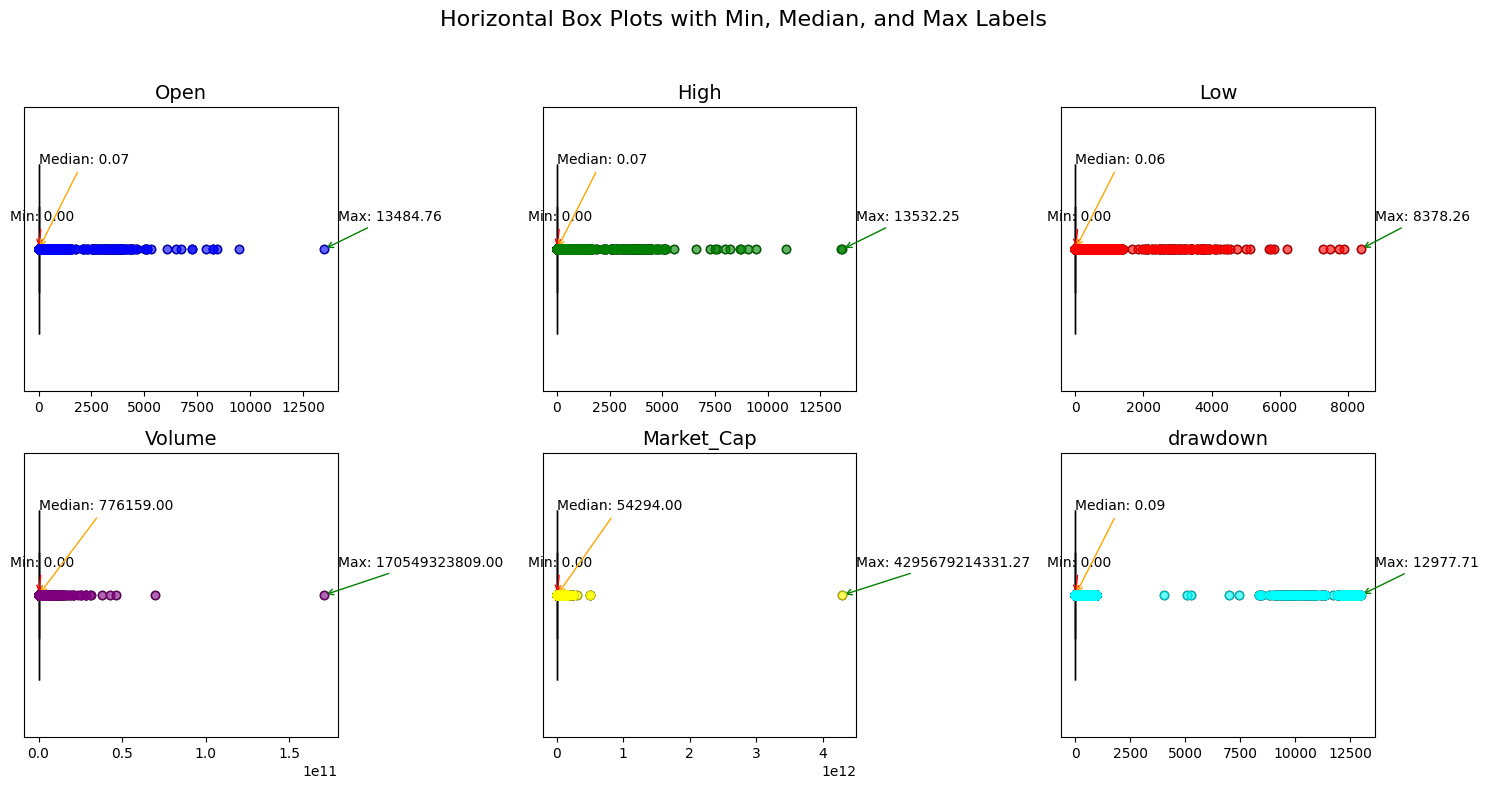

In [ ]:
columns = ['Open','High', 'Low', 'Volume','Market_Cap', 'drawdown']
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow', 'lightgray']
data_point_colors = ['blue', 'green', 'red', 'purple', 'yellow', 'Cyan']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Horizontal Box Plots with Min, Median, and Max Labels", fontsize=16)
for i, col in enumerate(columns):
    row, col_num = divmod(i, 3)
    ax = axes[row, col_num]
    bp = ax.boxplot(df[col], vert=False, patch_artist=True, widths=0.6,boxprops=dict(color='black'),medianprops=dict(color='black'))
    for patch in bp['boxes']:
        patch.set_facecolor(colors[i])
    ax.scatter(df[col], [1] * len(df), color=data_point_colors[i], alpha=0.6, label="Data Points", zorder=5)
    min_val = df[col].min()
    median_val = df[col].median()
    max_val = df[col].max()
    ax.set_title(col, fontsize=14)
    ax.set_yticks([])
    ax.annotate(f"Min: {min_val:.2f}", xy=(min_val, 1), xytext=(min_val - (max_val * 0.1), 1.1),arrowprops=dict(arrowstyle="->", color='red'))
    ax.annotate(f"Median: {median_val:.2f}", xy=(median_val, 1), xytext=(median_val, 1.3),arrowprops=dict(arrowstyle="->", color='orange'))
    ax.annotate(f"Max: {max_val:.2f}", xy=(max_val, 1), xytext=(max_val + (max_val * 0.05), 1.1),arrowprops=dict(arrowstyle="->", color='green'))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 7. Correlation

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'coin', 'Market_Cap',
       'Pct_Change', 'Month_Year', 'PD', 'isPenny', 'drawdown',
       'drawdown_percentage', 'Open_1m_avg', 'Open_3m_avg', 'Open_6m_avg',
       'Open_12m_avg', 'Open_24m_avg', 'Open_1m_std', 'Open_3m_std',
       'Open_6m_std', 'Open_12m_std', 'Open_24m_std', 'Open_1m_volatility',
       'Open_3m_volatility', 'Open_6m_volatility', 'Open_12m_volatility',
       'Open_24m_volatility'],
      dtype='object')

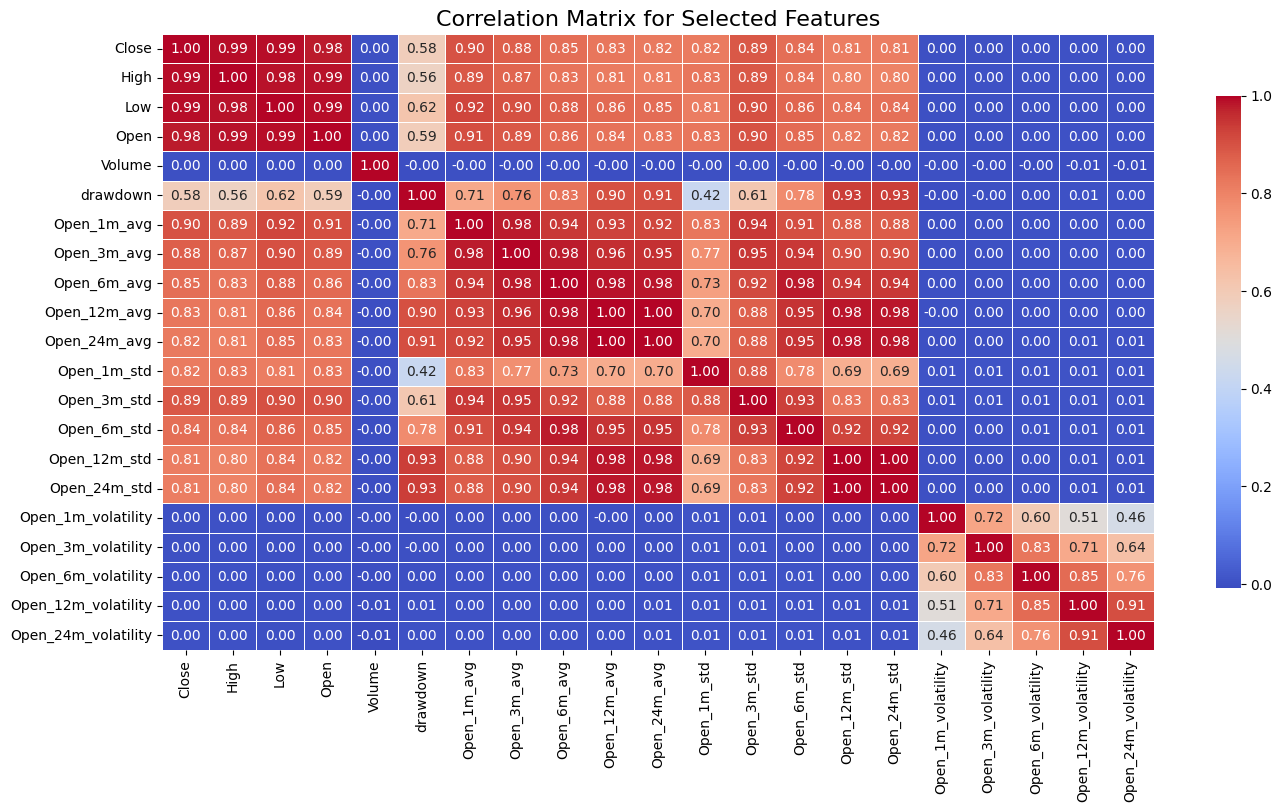

In [ ]:
corr_matrix = df[['Close', 'High', 'Low', 'Open', 'Volume', 'drawdown', 'Open_1m_avg', 'Open_3m_avg', 'Open_6m_avg', 'Open_12m_avg',
       'Open_24m_avg', 'Open_1m_std', 'Open_3m_std', 'Open_6m_std',
       'Open_12m_std', 'Open_24m_std', 'Open_1m_volatility',
       'Open_3m_volatility', 'Open_6m_volatility', 'Open_12m_volatility',
       'Open_24m_volatility']].corr()

plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix for Selected Features', fontsize=16)
plt.show()

# 8. Penny Crypto

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,coin,Market_Cap,Pct_Change,Month_Year,...,Open_1m_std,Open_3m_std,Open_6m_std,Open_12m_std,Open_24m_std,Open_1m_volatility,Open_3m_volatility,Open_6m_volatility,Open_12m_volatility,Open_24m_volatility
0,2019-01-01,0.002876,0.002930,0.002784,0.002913,331289.0,AAC,965.044878,0.000000,2019-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,0.002928,0.002953,0.002757,0.002872,305086.0,AAC,876.206987,-1.407486,2019-01-02,...,0.000037,0.000037,0.000037,0.000037,0.000037,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,0.002869,0.003170,0.002736,0.002900,317624.0,AAC,921.109588,0.974930,2019-01-03,...,0.000032,0.000032,0.000032,0.000032,0.000032,0.027033,0.027033,0.027033,0.027033,0.027033
3,2019-01-04,0.002898,0.002986,0.002797,0.002901,435891.0,AAC,1264.519778,0.034483,2019-01-04,...,0.000027,0.000027,0.000027,0.000027,0.000027,0.020169,0.020169,0.020169,0.020169,0.020169
4,2019-01-05,0.002898,0.003046,0.002845,0.002907,518812.0,AAC,1508.186493,0.206827,2019-01-05,...,0.000023,0.000023,0.000023,0.000023,0.000023,0.016522,0.016522,0.016522,0.016522,0.016522


In [ ]:
df.groupby(['isPenny','PD'])['Open'].count().reset_index()

,isPenny,PD,Open
0,0,0.0,27146
1,0,1.0,79
2,1,0.0,155148
3,1,1.0,482


In [ ]:
group_counts=df[df['PD']==1]

group_counts = group_counts.groupby(['isPenny'])['Open'].count().reset_index()

total_count = group_counts['Open'].count()
group_counts['Percentage'] = round((group_counts['Open'] / total_count) * 100,2)

group_counts

,isPenny,Open,Percentage
0,0,79,3950.0
1,1,482,24100.0


In [ ]:
group_counts = df[df['PD'] == 1]
group_counts = group_counts.groupby(['isPenny'])['Open'].count().reset_index()
total_count = len(df[df['PD'] == 1])
group_counts['Percentage'] = round((group_counts['Open'] / total_count) * 100, 2)
group_counts.rename(columns={"Open":"PD Count"},inplace=True)
group_counts

,isPenny,PD Count,Percentage
0,0,79,14.08
1,1,482,85.92


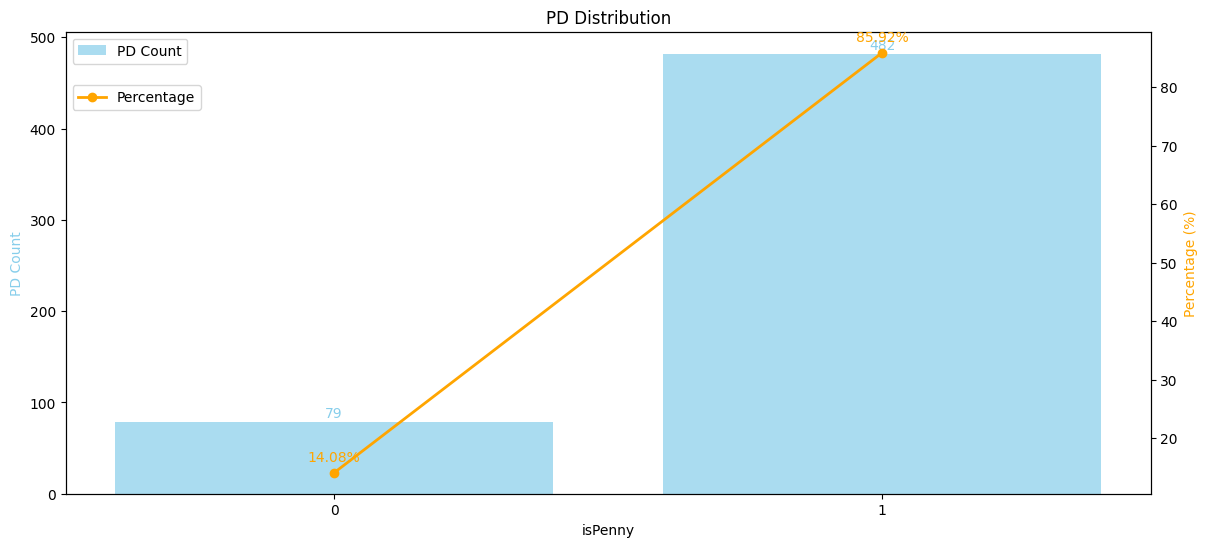

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 6))
bars = ax1.bar(group_counts['isPenny'], group_counts['PD Count'], color='skyblue', label='PD Count', alpha=0.7)
ax1.set_ylabel('PD Count', color='skyblue')
ax2 = ax1.twinx()
line, = ax2.plot(group_counts['isPenny'], group_counts['Percentage'], color='orange', marker='o', label='Percentage', linewidth=2)
ax2.set_ylabel('Percentage (%)', color='orange')
ax1.set_xlabel('isPenny')
ax1.set_title('PD Distribution')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height), ha='center', color='skyblue')
for x, y in zip(group_counts['isPenny'], group_counts['Percentage']):
    ax2.text(x, y + 2, f'{y}%', ha='center', color='orange')
ax1.set_xticks([0, 1])
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
plt.show()

In [ ]:
d = df[df['Open'] <=1]
fig = go.Figure()
fig.add_trace(go.Histogram(x=d['Open'],nbinsx=500,marker_color='blue',opacity=0.7,name='Open Price Distribution'  ))

pd_ones = d[d['PD'] == 1]
if not pd_ones.empty:
    fig.add_trace(go.Scatter(x=pd_ones['Open'],y=[0] * len(pd_ones),  mode='markers',marker=dict(color='red', size=10, symbol='star'),  name='PD Event'))

fig.update_layout(title='Distribution of Open Prices with PD Events',xaxis_title='Open Prices',yaxis_title='Frequency',title_x=0.5,template='plotly_white',bargap=0.05,height=500,width=1500,showlegend=True)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

# 9. Distribution Features and PD

<ipython-input-31-dd043e581ba3>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-31-dd043e581ba3>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-31-dd043e581ba3>:13: FutureWarning:

Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.

<ipython-input-31-dd043e581ba3>:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-31-dd043e581ba3>:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` a

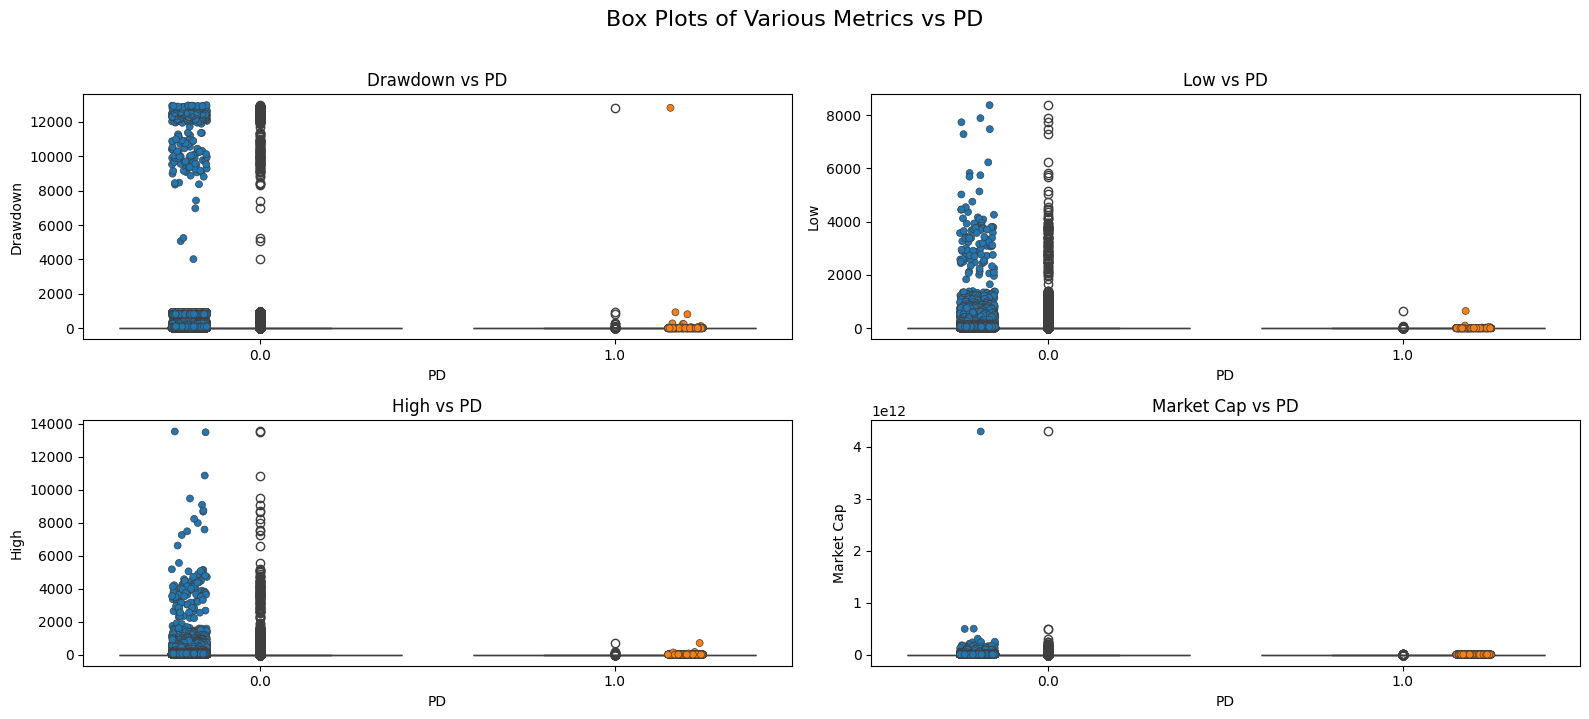

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 7))
fig.suptitle("Box Plots of Various Metrics vs PD", fontsize=16, y=1.02)

# Colors for data points
colors = ['#1f77b4', '#ff7f0e']  # Choose distinct colors for PD categories (modify as needed)

# Drawdown vs PD
sns.boxplot(x='PD', y='drawdown', data=df, ax=axes[0, 0], palette=colors)
sns.stripplot(x='PD', y='drawdown', data=df, ax=axes[0, 0], jitter=True, dodge=True, marker='o', edgecolor="gray", linewidth=0.5, palette=colors)
axes[0, 0].set_title("Drawdown vs PD", fontsize=12)
axes[0, 0].set_xlabel("PD")
axes[0, 0].set_ylabel("Drawdown")

# Low vs PD
sns.boxplot(x='PD', y='Low', data=df, ax=axes[0, 1], palette=colors)
sns.stripplot(x='PD', y='Low', data=df, ax=axes[0, 1], jitter=True, dodge=True, marker='o', edgecolor="gray", linewidth=0.5, palette=colors)
axes[0, 1].set_title("Low vs PD", fontsize=12)
axes[0, 1].set_xlabel("PD")
axes[0, 1].set_ylabel("Low")

# High vs PD
sns.boxplot(x='PD', y='High', data=df, ax=axes[1, 0], palette=colors)
sns.stripplot(x='PD', y='High', data=df, ax=axes[1, 0], jitter=True, dodge=True, marker='o', edgecolor="gray", linewidth=0.5, palette=colors)
axes[1, 0].set_title("High vs PD", fontsize=12)
axes[1, 0].set_xlabel("PD")
axes[1, 0].set_ylabel("High")

# Market Cap vs PD
sns.boxplot(x='PD', y='Market_Cap', data=df, ax=axes[1, 1], palette=colors)
sns.stripplot(x='PD', y='Market_Cap', data=df, ax=axes[1, 1], jitter=True, dodge=True, marker='o', edgecolor="gray", linewidth=0.5, palette=colors)
axes[1, 1].set_title("Market Cap vs PD", fontsize=12)
axes[1, 1].set_xlabel("PD")
axes[1, 1].set_ylabel("Market Cap")

# Adjust layout for a cleaner look
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Space for the main title
plt.show()


# 10. Market Cap Category

In [ ]:
import plotly.express as px
import pandas as pd

# Create market_cap_category as before
df['market_cap_category'] = pd.cut(df['Market_Cap'], bins=[0, 1e6, 1e9, 1e12], labels=['Micro', 'Small', 'Large'])

# Group by 'market_cap_category' and 'PD' to count occurrences
pd_counts = df.groupby(['market_cap_category', 'PD']).size().reset_index(name='Count')

# Add a new column for labels, only showing labels for PD=1
pd_counts['Label'] = pd_counts.apply(lambda row: row['Count'] if row['PD'] == 1 else '', axis=1)

# Plotting with Plotly and adding labels for PD=1
fig = px.bar(
    pd_counts,
    x='market_cap_category',
    y='Count',
    color='PD',
    title='PD Distribution Across Market Cap Categories',
    labels={'market_cap_category': 'Market Cap Category', 'Count': 'Frequency'},
    barmode='stack',
    color_discrete_sequence=['blue', 'red']
)

# Add labels for PD=1 counts
fig.update_traces(text=pd_counts['Label'], textposition='outside')

# Show the plot
fig.show()


<ipython-input-25-74b17de0e628>:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'coin', 'Market_Cap',
       'Pct_Change', 'Month_Year', 'PD', 'isPenny', 'drawdown',
       'drawdown_percentage', 'Open_1m_avg', 'Open_3m_avg', 'Open_6m_avg',
       'Open_12m_avg', 'Open_24m_avg', 'Open_1m_std', 'Open_3m_std',
       'Open_6m_std', 'Open_12m_std', 'Open_24m_std', 'Open_1m_volatility',
       'Open_3m_volatility', 'Open_6m_volatility', 'Open_12m_volatility',
       'Open_24m_volatility', 'market_cap_category'],
      dtype='object')

# 11. Rolling Features

In [ ]:
import plotly.express as px
import pandas as pd

# Filter out the relevant columns
features = ['Open_1m_avg', 'Open_24m_avg', 'Open_1m_std', 'Open_24m_std',
            'Open_1m_volatility', 'Open_24m_volatility', 'PD']

# Create a DataFrame with just the selected columns
df_features = df[features]

# Reshape data to a long format for easy plotting
df_long = pd.melt(
    df_features,
    id_vars='PD',
    value_vars=['Open_1m_avg', 'Open_24m_avg', 'Open_1m_std', 'Open_24m_std',
                'Open_1m_volatility', 'Open_24m_volatility'],
    var_name='Feature',
    value_name='Value'
)

# Separate the feature type (avg, std, volatility) and the time period (1m, 24m) for clarity
df_long['Type'] = df_long['Feature'].apply(lambda x: x.split('_')[2])  # Extract avg, std, volatility
df_long['Time'] = df_long['Feature'].apply(lambda x: x.split('_')[1] + ' Month')  # Extract 1m, 24m

# Plot using Plotly Express
fig = px.box(
    df_long,
    x='Type',
    y='Value',
    color='PD',
    facet_col='Time',  # Separate columns for 1 Month and 24 Month
    title="Comparison of 1-Month and 24-Month Averages, Standard Deviations, and Volatilities with PD",
    labels={'Value': 'Feature Value', 'Type': 'Feature Type'},
    color_discrete_sequence=['blue', 'red']
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Feature Type (Average, Std, Volatility)',
    yaxis_title='Feature Value',
    title_x=0.5,  # Center title
    template='plotly_white'
)

fig.show()


Output hidden; open in https://colab.research.google.com to view.